# [실험 재설계] 숫자 '3' 데이터만 사용한 오토인코더 분석

## 가설
1. **모델 A (가중치=1 초기화):** 은닉층의 대칭성 문제로 인해 입력 데이터('3')의 특징을 제대로 학습하지 못하고, 원본 이미지를 제대로 재구성하지 못할 것이다.
2. **모델 B (표준 초기화):** 데이터의 특징을 정상적으로 학습하여 원본과 유사한 이미지를 재구성해낼 것이다.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.initializers import Initializer

try:
    import koreanize_matplotlib
except ImportError:
    !pip install koreanize_matplotlib
    import koreanize_matplotlib

### 1. 데이터 준비 (숫자 '3' 데이터만 필터링)

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 데이터 정규화
x_train, x_test = x_train / 255.0, x_test / 255.0

# 레이블이 3인 데이터만 필터링
x_train_3 = x_train[y_train == 3]
x_test_3 = x_test[y_test == 3]

훈련용 '3' 데이터 개수: 6131
테스트용 '3' 데이터 개수: 1010


In [5]:
print(f"훈련용 '3' 데이터 개수: {np.shape(x_train_3)}")
print(f"테스트용 '3' 데이터 개수: {np.shape(x_test_3)}")

훈련용 '3' 데이터 개수: (6131, 28, 28)
테스트용 '3' 데이터 개수: (1010, 28, 28)


In [6]:
np.mean(x_train)

np.float64(0.1306604762738429)

### 2. 오토인코더 모델 생성

In [7]:
# 모든 가중치를 1로 설정하는 커스텀 초기화 클래스
class OnesInitializer(Initializer):
    def __call__(self, shape, dtype=None):
        return tf.ones(shape, dtype=dtype)

def create_autoencoder(initializer):
    # 인코더: 입력 이미지를 32차원으로 압축
    encoder = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),
        tf.keras.layers.Dense(64, activation='relu', kernel_initializer=initializer, bias_initializer='zeros'),
        tf.keras.layers.Dense(32, activation='relu', kernel_initializer=initializer, bias_initializer='zeros') # 잠재 공간(Latent Space)
    ])

    # 디코더: 압축된 특징을 다시 784차원(28x28) 이미지로 복원
    decoder = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(32,)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(784, activation='sigmoid'), # 픽셀 값(0~1)으로 복원하기 위해 sigmoid 사용
        tf.keras.layers.Reshape((28, 28))
    ])

    autoencoder = tf.keras.models.Sequential([encoder, decoder])
    return autoencoder

# 모델 A: 인코더 가중치를 1로 초기화
autoencoder_A = create_autoencoder(OnesInitializer())

# 모델 B: 표준 무작위 초기화
autoencoder_B = create_autoencoder('glorot_uniform')

# 두 모델을 동일한 조건으로 컴파일 (손실 함수로 mse 사용)
autoencoder_A.compile(optimizer='adam', loss='mean_squared_error')
autoencoder_B.compile(optimizer='adam', loss='mean_squared_error')

autoencoder_A.summary()

c:\Users\brigh\Documents\GitHub\AI-Lab\venv\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
c:\Users\brigh\Documents\GitHub\AI-Lab\venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 32)             │       110,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 28, 28)         │       111,568 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

### 3. 모델 학습
오토인코더는 입력(x)과 정답(y)이 모두 원본 이미지로 동일합니다.

In [8]:
epochs = 20
batch_size = 128

print("모델 A 학습 시작...")
# 입력(x)과 타겟(y)에 모두 x_train_3를 넣어줌
history_A = autoencoder_A.fit(x_train_3, x_train_3,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(x_test_3, x_test_3),
                            verbose=1)

print("\n모델 B 학습 시작...")
history_B = autoencoder_B.fit(x_train_3, x_train_3,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(x_test_3, x_test_3),
                            verbose=1)

모델 A 학습 시작...
Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 9/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 10/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 11/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4603 - val_loss: 0.4602
Epoch 12/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 

### 4. 결과 시각화 및 분석
테스트 데이터셋의 원본 이미지와 각 모델이 재구성한 이미지를 비교합니다.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


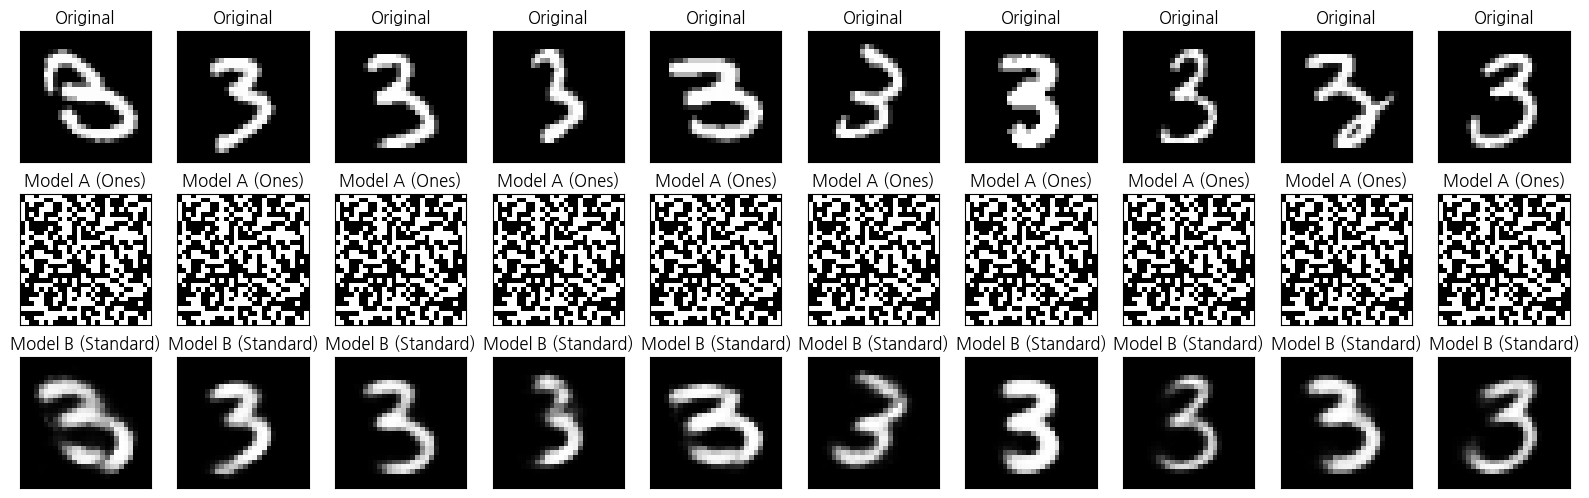

In [9]:
# 테스트 이미지로 예측 생성
decoded_imgs_A = autoencoder_A.predict(x_test_3)
decoded_imgs_B = autoencoder_B.predict(x_test_3)

# 시각화
n = 10  # 보여줄 이미지 개수
plt.figure(figsize=(20, 6))

for i in range(n):
    # 원본 이미지
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test_3[i], cmap='gray')
    ax.set_title("Original")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 모델 A 재구성 이미지
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(decoded_imgs_A[i], cmap='gray')
    ax.set_title("Model A (Ones)")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # 모델 B 재구성 이미지
    ax = plt.subplot(3, n, i + 1 + n * 2)
    plt.imshow(decoded_imgs_B[i], cmap='gray')
    ax.set_title("Model B (Standard)")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [10]:
autoencoder_A.weights

[<Variable path=sequential/dense/kernel, shape=(784, 128), dtype=float32, value=[[1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  ...
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]
  [1. 1. 1. ... 1. 1. 1.]]>,
 <Variable path=sequential/dense/bias, shape=(128,), dtype=float32, value=[-2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24 -2.841566e-24
  -2.841566e-24 -2.841566e-24 -2.84